# Clasificación con Árboles de Decisión

En este notebook, abordamos un problema de clasificación multietiqueta utilizando árboles de decisión. Nuestro objetivo es predecir la probabilidad de vacunación contra el H1N1 y la gripe estacional. A continuación, describimos el proceso en detalle.

El algoritmo que vamos a utilizar es el árbol de decisión CART (Classification and Regression Trees). Lo aplicaremos con DecisionTreeClassifier de Scikit-learn que hace referencia al árbol de clasificación. Este árbol divide el espacio de características en regiones disjuntas mediante divisiones binarias (cada nodo tiene a lo sumo dos hijos).

In [2]:
import pandas as pd
import numpy as np
import optuna
import os
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import plot_tree

c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\1er Cuatrimestre\Minería de Datos. Preprocesamiento y clasificación\FluShotLearning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Importar los datos

Cargamos los datos preprocesados y divididos tras aplicar train_test_split. El dataset ya ha sido tratado para manejar valores faltantes y aplicar codificaciones necesarias.

In [3]:
X_train = pd.read_csv("../../Data/preprocessed_X_train.csv", index_col="respondent_id")
X_test = pd.read_csv("../../Data/preprocessed_X_test.csv", index_col="respondent_id")
y_train = pd.read_csv("../../Data/preprocessed_y_train.csv", index_col="respondent_id")
y_test = pd.read_csv("../../Data/preprocessed_y_test.csv", index_col="respondent_id")

## 2. Entrenar un árbol de decisión

Utilizamos el modelo DecisionTreeClassifier de Scikit-Learn y lo envolvemos en un MultiOutputClassifier para manejar el problema multietiqueta. Realizamos una búsqueda de hiperparámetros utilizando la librería optuna.

In [4]:
def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    param_grid = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 5, 10, step=1),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 20, step=1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 25, step=1),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.1, step=0.01),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }

    # Modelo base
    cart_model = DecisionTreeClassifier(random_state=42, **param_grid)
    multi_cart = MultiOutputClassifier(cart_model)

    # Validación cruzada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in skf.split(X_train, y_train['h1n1_vaccine']):  # Usa una etiqueta para dividir
        # Dividir los datos
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Entrenar y evaluar el modelo
        multi_cart.fit(X_train_fold, y_train_fold)
        y_proba = multi_cart.predict_proba(X_val_fold)

        # Calcular AUROC para cada etiqueta
        roc_auc_h1n1 = roc_auc_score(y_val_fold['h1n1_vaccine'], y_proba[0][:, 1])
        roc_auc_seasonal = roc_auc_score(y_val_fold['seasonal_vaccine'], y_proba[1][:, 1])
        scores.append(np.mean([roc_auc_h1n1, roc_auc_seasonal]))

    return np.mean(scores)

In [5]:
# Configurar Optuna
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)

# Ejecutar Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=200, show_progress_bar=True)

[I 2025-01-26 13:10:43,829] A new study created in memory with name: no-name-ed9440dc-f5b6-4f07-ac0f-5742f4ad722c
Best trial: 149. Best value: 0.834712: 100%|██████████| 200/200 [03:04<00:00,  1.09it/s]


In [6]:
# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", study.best_params)
print("Mejor puntuación AUROC:", study.best_value)

# Entrenar el modelo final con los mejores hiperparámetros
best_params = study.best_params
cart_model = DecisionTreeClassifier(random_state=42, **best_params)
multi_cart = MultiOutputClassifier(cart_model)
multi_cart.fit(X_train, y_train)

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': None, 'min_impurity_decrease': 0.0, 'splitter': 'best', 'class_weight': None}
Mejor puntuación AUROC: 0.8347119576440172


MultiOutputClassifier(estimator=DecisionTreeClassifier(max_depth=6,
                                                       min_samples_leaf=10,
                                                       min_samples_split=9,
                                                       random_state=42))

# 3. Evaluar el modelo

Calculamos las métricas de rendimiento como la precisión, el recall, el F1-score y la exactitud.

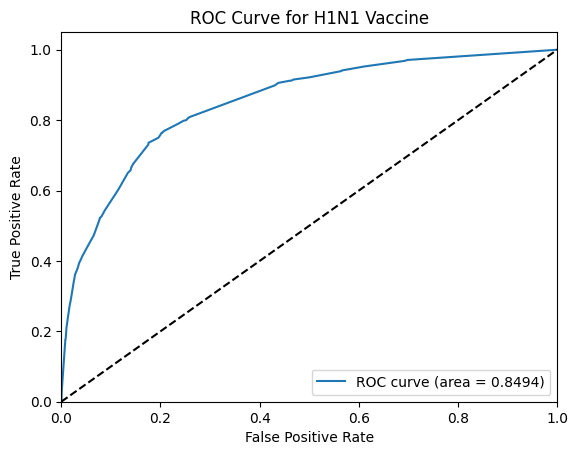

In [7]:
# Predicciones y probabilidades
y_pred = multi_cart.predict(X_test)
y_proba = multi_cart.predict_proba(X_test)

# Evaluación para H1N1
h1n1_probabilities = y_proba[0][:, 1]
h1n1_predictions = y_pred[:, 0]
roc_auc_h1n1 = roc_auc_score(y_test['h1n1_vaccine'], h1n1_probabilities)
accuracy_h1n1 = accuracy_score(y_test['h1n1_vaccine'], h1n1_predictions)

# Curva ROC para H1N1
fpr_h1n1, tpr_h1n1, _ = roc_curve(y_test['h1n1_vaccine'], h1n1_probabilities)
plt.figure()
plt.plot(fpr_h1n1, tpr_h1n1, label=f'ROC curve (area = {roc_auc_h1n1:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for H1N1 Vaccine')
plt.legend(loc="lower right")
plt.show()

In [8]:
print(f"AUROC para H1N1: {roc_auc_h1n1}")
print(f"Accuracy para H1N1: {accuracy_h1n1}")

AUROC para H1N1: 0.8494150194400145
Accuracy para H1N1: 0.8420067390490453


In [9]:
# Generar y mostrar el classification report para H1N1
print("Classification Report for H1N1 Vaccine:")
print(classification_report(y_test['h1n1_vaccine'], h1n1_predictions, target_names=["No", "Yes"]))

Classification Report for H1N1 Vaccine:
              precision    recall  f1-score   support

          No       0.86      0.96      0.91      4207
         Yes       0.72      0.41      0.53      1135

    accuracy                           0.84      5342
   macro avg       0.79      0.69      0.72      5342
weighted avg       0.83      0.84      0.82      5342



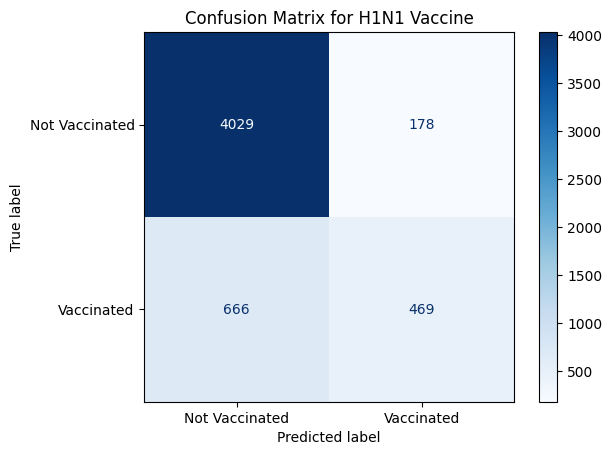

In [10]:
# Matriz de confusión del modelo
conf_matrix= confusion_matrix(y_test['h1n1_vaccine'], h1n1_predictions)
disp= ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Vaccinated', 'Vaccinated'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for H1N1 Vaccine")
plt.show()

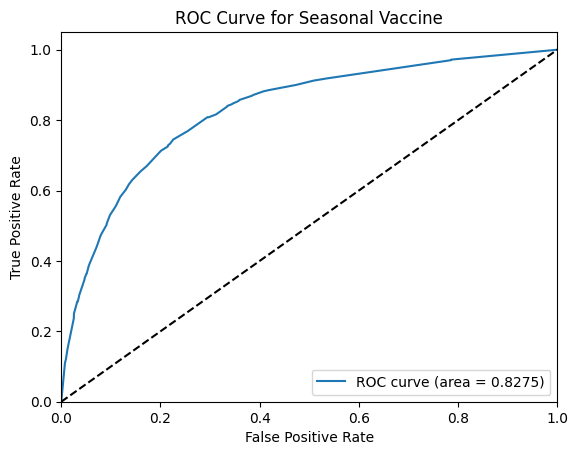

In [11]:
# Evaluación para Vacuna Estacional
seasonal_probabilities = y_proba[1][:, 1]
seasonal_predictions = y_pred[:, 1]
roc_auc_seasonal = roc_auc_score(y_test['seasonal_vaccine'], seasonal_probabilities)
accuracy_seasonal = accuracy_score(y_test['seasonal_vaccine'], seasonal_predictions)

# Curva ROC para Vacuna Estacional
fpr_seasonal, tpr_seasonal, _ = roc_curve(y_test['seasonal_vaccine'], seasonal_probabilities)
plt.figure()
plt.plot(fpr_seasonal, tpr_seasonal, label=f'ROC curve (area = {roc_auc_seasonal:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Seasonal Vaccine')
plt.legend(loc="lower right")
plt.show()

In [12]:
print(f"AUROC para Vacuna Estacional: {roc_auc_seasonal}")
print(f"Accuracy para Vacuna Estacional: {accuracy_seasonal}")

AUROC para Vacuna Estacional: 0.8275482653104911
Accuracy para Vacuna Estacional: 0.7572070385623362


In [13]:
# Generar y mostrar el classification report para seasonal
print("Classification Report for seasonal Vaccine:")
print(classification_report(y_test['seasonal_vaccine'], seasonal_predictions, target_names=['Not Vaccinated', 'Vaccinated']))

Classification Report for seasonal Vaccine:
                precision    recall  f1-score   support

Not Vaccinated       0.77      0.79      0.78      2854
    Vaccinated       0.75      0.73      0.74      2488

      accuracy                           0.76      5342
     macro avg       0.76      0.76      0.76      5342
  weighted avg       0.76      0.76      0.76      5342



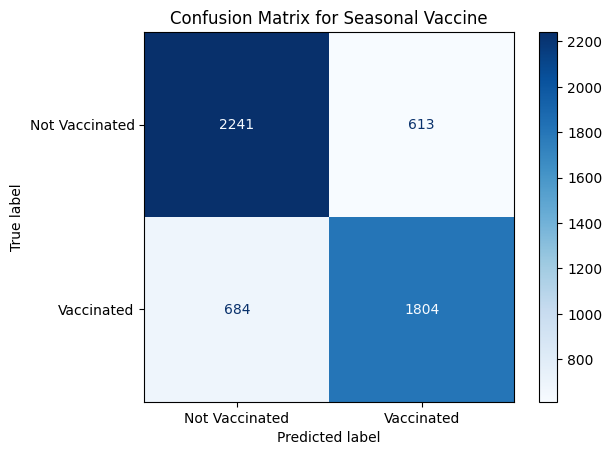

In [15]:
# Matriz de confusión para Vacuna Estacional
conf_matrix_seasonal = confusion_matrix(y_test['seasonal_vaccine'], seasonal_predictions)
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_seasonal, display_labels=['Not Vaccinated', 'Vaccinated'])
disp_seasonal.plot(cmap='Blues')
plt.title("Confusion Matrix for Seasonal Vaccine")
plt.show()

# 4. Visualizar el árbol de decisión

Podemos visualizar el árbol para comprender cómo toma decisiones.

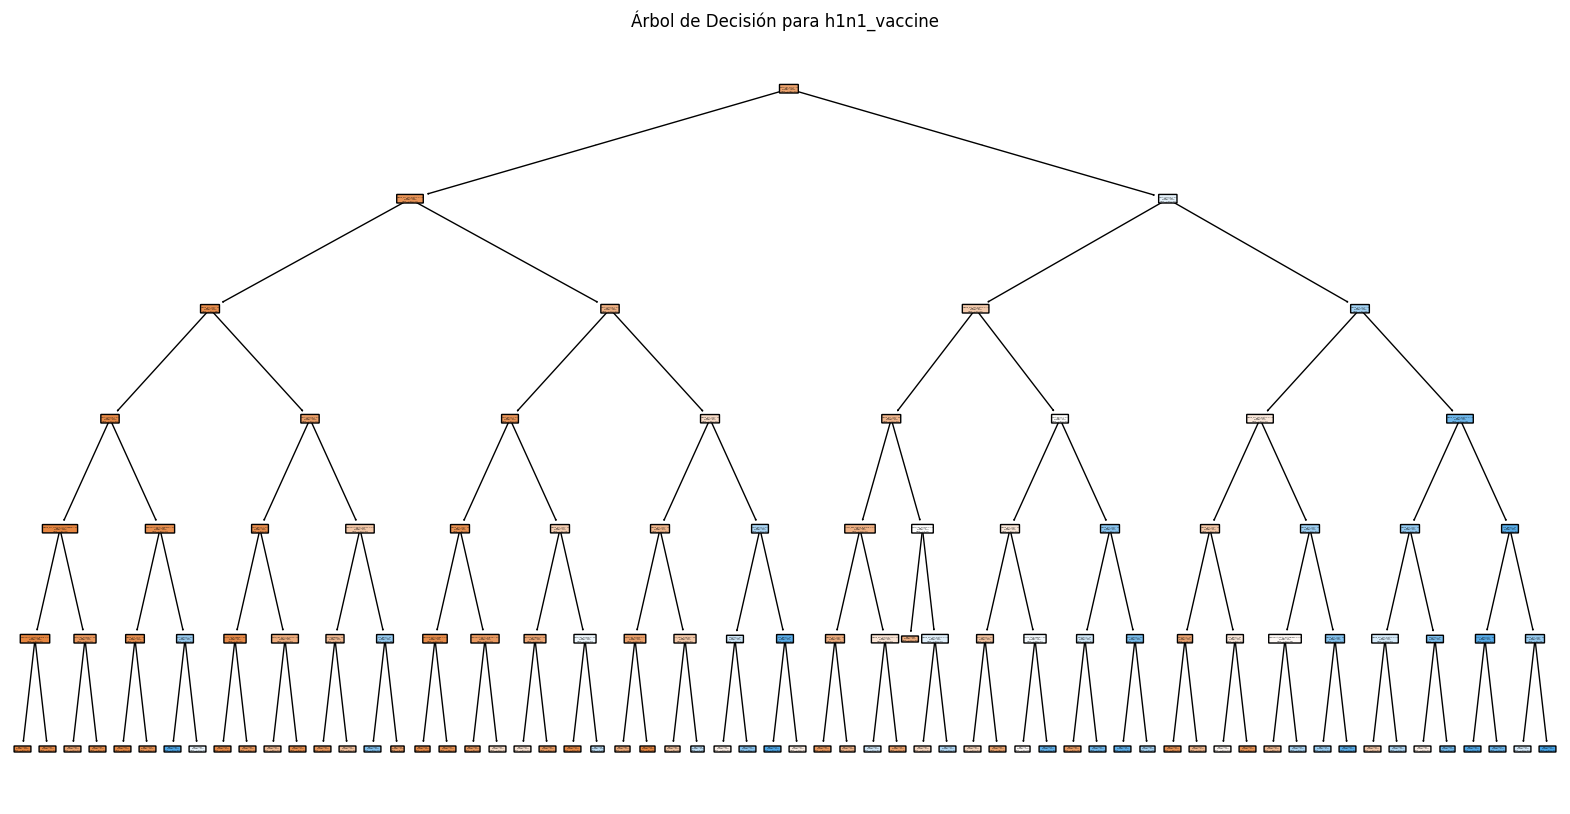

In [16]:
# Obtener el modelo optimizado
best_tree_h1n1 = multi_cart.estimators_[0]

# Visualizar el árbol
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree_h1n1,
    filled=True,
    feature_names=X_train.columns,  # Nombres de las características
    class_names=["No", "Yes"],      # Etiquetas de las clases
    rounded=True,
    proportion=True
)
plt.title("Árbol de Decisión para h1n1_vaccine")
plt.show()

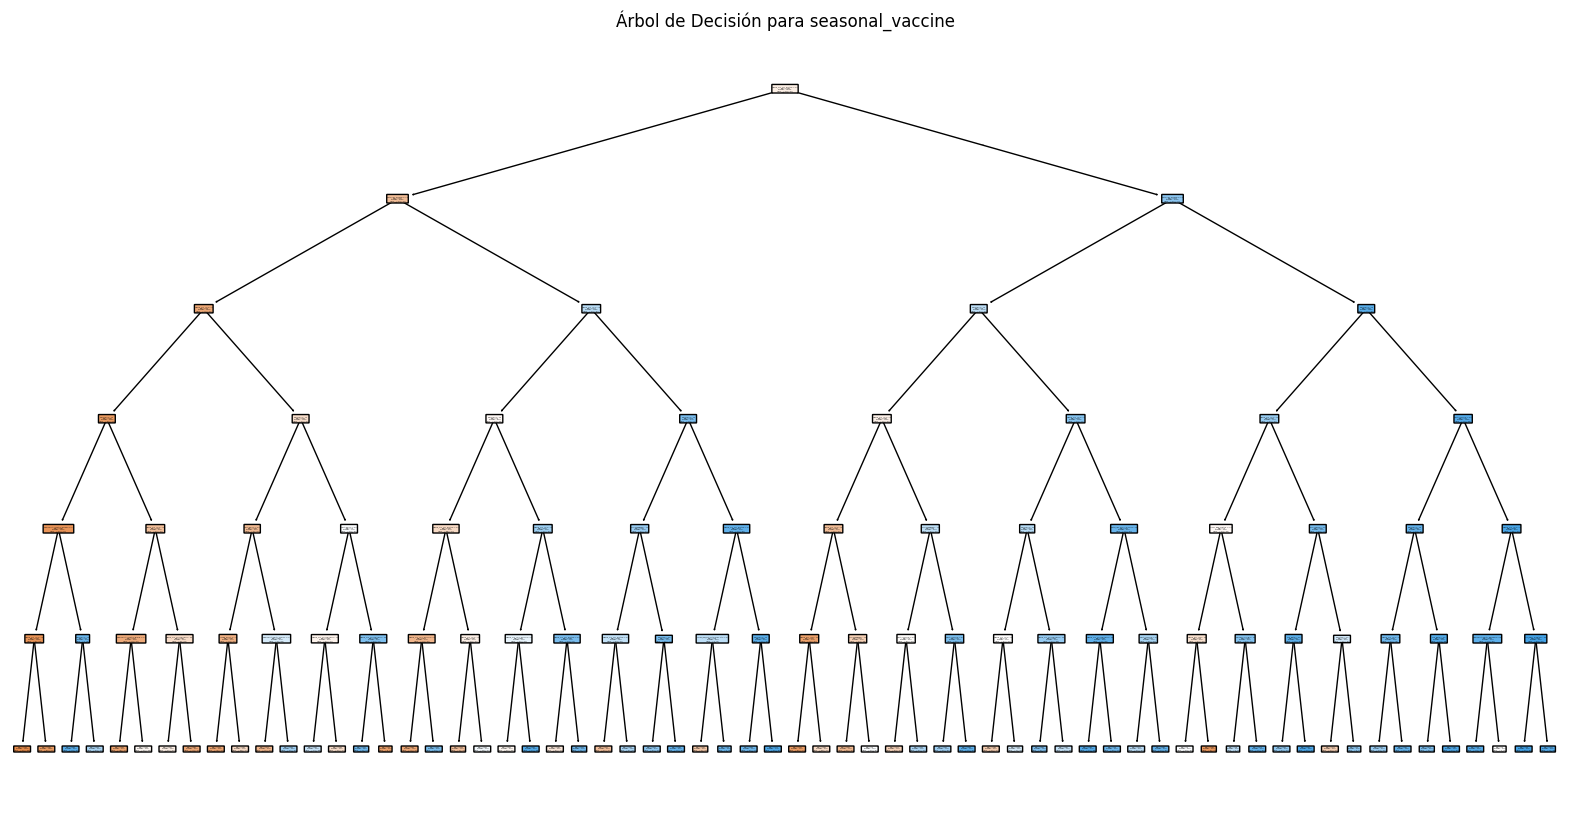

In [17]:
# Árbol para la segunda etiqueta (seasonal_vaccine)
best_tree_seasonal = multi_cart.estimators_[1]

# Visualizar el árbol
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree_seasonal,
    filled=True,
    feature_names=X_train.columns,
    class_names=["No", "Yes"],
    rounded=True,
    proportion=True
)
plt.title("Árbol de Decisión para seasonal_vaccine")
plt.show()

## 5. Guardar el modelo

Si el modelo supera las métricas del modelo anterior lo guardamos para tener el mejor modelo siempre guardado.

In [18]:
def save_model_if_better(model, current_roc_auc, model_path, metric_path):

    # Cargar la métrica del modelo previo si existe
    if os.path.exists(metric_path):
        with open(metric_path, "r") as f:
            best_roc_auc = float(f.read().strip())
    else:
        best_roc_auc = 0.0
    
    print(f"Current ROC AUC: {current_roc_auc:.4f} | Best ROC AUC: {best_roc_auc:.4f}")

    # Comparar y guardar el modelo si mejora
    if current_roc_auc > best_roc_auc:
        print("El modelo es mejor que el anterior...")
        joblib.dump(model, model_path)  # Guardar el modelo
        with open(metric_path, "w") as f:
            f.write(f"{current_roc_auc:.4f}")  # Guardar la métrica actual
    else:
        print("El modelo no es mejor que el anterior. Saltando el guardado.")

In [20]:
current_roc_auc = (roc_auc_seasonal + roc_auc_h1n1) / 2
model_path = "Modelos/DecissionTree_best_model.pkl"
metric_path = "Modelos/DecissionTree_best_roc_auc.txt"
save_model_if_better(multi_cart, current_roc_auc, model_path, metric_path)

Current ROC AUC: 0.8385 | Best ROC AUC: 0.8351
El modelo es mejor que el anterior...


# 6. Archivo de envío a la competición

Cargamos el dataset de prueba de la competición para obtener los resultados del modelo.

In [21]:
# Cargar el dataset de prueba preprocesado
test_set_preprocessed = pd.read_csv("../../Data/preprocessed_test_set_features.csv")

# Asegurarse de que respondent_id esté disponible
respondent_ids = test_set_preprocessed['respondent_id']

# Eliminar respondent_id del conjunto de características
X_test_final = test_set_preprocessed.drop(columns=['respondent_id'])

# Realizar predicciones de probabilidad
y_proba_test = multi_cart.predict_proba(X_test_final)

# Extraer las probabilidades para la clase positiva (1)
y_proba_h1n1_test = y_proba_test[0][:, 1]  # Probabilidades para H1N1
y_proba_seasonal_test = y_proba_test[1][:, 1]  # Probabilidades para vacuna estacional

# Crear el DataFrame de submission
submission = pd.DataFrame({
    "respondent_id": respondent_ids,
    "h1n1_vaccine": y_proba_h1n1_test,
    "seasonal_vaccine": y_proba_seasonal_test
})

# Guardar el archivo de submission
submission.to_csv("Submissions/DecisionTree_submission.csv", index=False)
print("Archivo 'DecisionTree_submission.csv' generado correctamente.")

Archivo 'DecisionTree_submission.csv' generado correctamente.
